In [2]:
import sys, os

os.chdir("../")
sys.path.append("./src/data")
sys.path.append("./src/events")
sys.path.append("./src/probability")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import nufit_params_nsi, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import (
    get_param_list,
    list_of_params_nsi,
    marginalize,
    marginalize_one,
)
from DC.event_processing import get_deltachi as deltachi_DC
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
from scipy.interpolate import splrep, splev, sproot
from src.plotter import save, savethesis

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100
matplotlib.rc("text", usetex=True)
matplotlib.rc("text.latex", preamble=r"\usepackage{amsmath}")
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=4)
df_I = pd.DataFrame()
df_D = pd.DataFrame()
df_ID = pd.DataFrame()

df_P = pd.DataFrame()
df_PD = pd.DataFrame()
df_PID = pd.DataFrame()

In [3]:
from functions import r_earth

2 * r_earth

12742.0

In [3]:
ndim = 3
livetime = 3 * 365 * 24 * 3600  # Effective livetime
ordering = "NO"
IO = False if ordering == "NO" else True
worst_cases = {}
normal_cases = {}
best_cases = {}
chisq = {}
nsi_list = ["ett", "emt", "eem", "eet"]
experiment_list_full = ["P", "D", "PD", "I", "ID", "PID"]

ett = 7e-2
emt = 3e-2
eem = 3e-1
eet = 3e-1

sigma_a = 0.25
sigma_b = 0.04
f_PINGU = [0, 0.03, 0.05]
f_DC = 1
f_IC = [0.05, 0.1, 0.15]
N_IC = 13
N_nsi = 9
N_nsi_fine = 49
e_ranges = [
    np.linspace(-ett, ett, N_nsi),
    np.linspace(-emt, emt, N_nsi),
    np.linspace(-eem, eem, N_nsi),
    np.linspace(-eet, eet, N_nsi),
]
fine_e_ranges = [
    np.linspace(-ett, ett, N_nsi_fine),
    np.linspace(-emt, emt, N_nsi_fine),
    np.linspace(-eem, eem, N_nsi_fine),
    np.linspace(-eet, eet, N_nsi_fine),
]

In [4]:
for i, nsi_param in enumerate(nsi_list):
    ettN, emtN, eemN, eetN = 0, 0, 0, 0
    experiment_list = ["P", "D", "PD"]
    if nsi_param == "ett":
        ettN = 1
    elif nsi_param == "emt":
        emtN = 1
    elif nsi_param == "eem":
        eemN = 1
    elif nsi_param == "eet":
        eetN = 1
    dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range = get_param_list(
        dm31N=5,
        th23N=5,
        ett_tuple=(-ett, ett, N_nsi * ettN + 1),
        emt_tuple=(-emt, emt, N_nsi * emtN + 1),
        eem_tuple=(-eem, eem, N_nsi * eemN + 1),
        eet_tuple=(-eet, eet, N_nsi * eetN + 1),
        IO=IO,
    )
    param_dict = nufit_params_nsi_IO if ordering == "IO" else nufit_params_nsi
    param_list = list_of_params_nsi(
        param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range
    )

    H1_DC = (
        pickle.load(
            open(
                f"./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p",
                "rb",
            )
        )
        * livetime
    )

    H1_PINGU = (
        pickle.load(
            open(
                f"./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p",
                "rb",
            )
        )
        * livetime
    )

    H0_PINGU = (
        pickle.load(open(f"./pre_computed/H0_{ordering}_PINGU.p", "rb")) * livetime
    )

    if len(emt_range) > 1:
        H1_events_list = pickle.load(
            open(
                f"./pre_computed/H1_NO_IC_N{N_IC}_{len(dm31_range)}x{len(th23_range)}x{len(emt_range)}.p",
                "rb",
            )
        )
        H0_events = pickle.load(open(f"./pre_computed/H0_IC_N{N_IC}_nsi.p", "rb"))
        H0_normalized, H1_list_normalized = normalize_events(
            H0_events, H1_events_list, np.arange(0, 20)
        )
        H1_IC = np.array(H1_list_normalized)

    for case in range(3):
        if case == 0:
            case_dict = best_cases
        elif case == 1:
            case_dict = normal_cases
        elif case == 2:
            case_dict = worst_cases
        D_chisq, D_best_fit_index = deltachi_DC(
            H1_DC, 0, [sigma_a, sigma_b], f_DC, x0=[1, 0]
        )
        P_chisq, P_best_fit_index = deltachi_PINGU(
            H1_PINGU, H0_PINGU, 0, [sigma_a, sigma_b], f_PINGU[case], x0=[1, 0]
        )
        PD_chisq = P_chisq + D_chisq - P_chisq.min() - D_chisq.min()
        PD_best_fit_index = np.argmin(PD_chisq)
        chisq["D"] = D_chisq
        chisq["P"] = P_chisq
        chisq["PD"] = PD_chisq
        case_dict[f"D_{nsi_param}_index"] = D_best_fit_index
        case_dict[f"P_{nsi_param}_index"] = P_best_fit_index
        case_dict[f"PD_{nsi_param}_index"] = PD_best_fit_index

        if len(emt_range) > 1:
            experiment_list += ["I", "ID", "PID"]
            I_chisq, I_best_fit_index = deltachi_IC(
                H1_IC, 0, [sigma_a, sigma_b], f_IC[case], x0=[1, 0]
            )

            ID_chisq = D_chisq + I_chisq
            ID_best_fit_index = np.argmin(ID_chisq)
            PID_chisq = PD_chisq + I_chisq
            PID_best_fit_index = np.argmin(PID_chisq)
            I_chisq = I_chisq
            chisq["I"] = I_chisq
            chisq["ID"] = ID_chisq
            chisq["PID"] = PID_chisq
            case_dict[f"I_{nsi_param}_index"] = I_best_fit_index
            case_dict[f"ID_{nsi_param}_index"] = ID_best_fit_index
            case_dict[f"PID_{nsi_param}_index"] = PID_best_fit_index

        for experiment in experiment_list:
            marginalized_chisq = marginalize(
                chisq[experiment],
                dm31_range,
                th23_range,
                ett_range,
                emt_range,
                eem_range,
                eet_range,
            )[0]
            interpolated_chisq = splev(
                fine_e_ranges[i], splrep(e_ranges[i], marginalized_chisq.reshape(-1))
            )
            interpolated_deltachi = interpolated_chisq - interpolated_chisq.min()

            case_dict[f"{experiment}_{nsi_param}"] = interpolated_deltachi

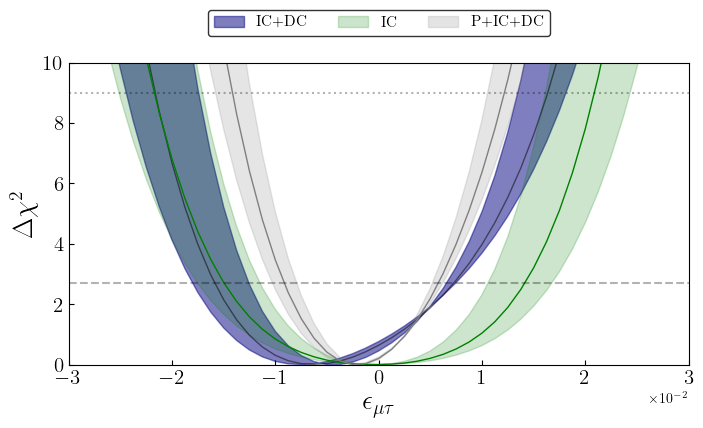

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
alpha_regions = 0.2
alpha_lines = 1
lw = 1

nsi_param = "emt"
ax.fill_between(
    fine_e_ranges[1],
    best_cases[f"ID_{nsi_param}"],
    worst_cases[f"ID_{nsi_param}"],
    label="IC+DC",
    alpha=alpha_regions + 0.3,
    color="navy",
)
ax.plot(
    fine_e_ranges[1],
    normal_cases[f"ID_{nsi_param}"],
    alpha=alpha_lines - 0.5,
    lw=lw,
    color="k",
)

ax.fill_between(
    fine_e_ranges[1],
    best_cases[f"I_{nsi_param}"],
    worst_cases[f"I_{nsi_param}"],
    label="IC",
    alpha=alpha_regions,
    color="g",
)
ax.plot(
    fine_e_ranges[1],
    normal_cases[f"I_{nsi_param}"],
    alpha=alpha_lines,
    lw=lw,
    color="g",
)

ax.fill_between(
    fine_e_ranges[1],
    best_cases[f"PID_{nsi_param}"],
    worst_cases[f"PID_{nsi_param}"],
    label="P+IC+DC",
    alpha=alpha_regions,
    color="grey",
)
ax.plot(
    fine_e_ranges[1],
    normal_cases[f"PID_{nsi_param}"],
    alpha=alpha_lines,
    lw=lw,
    color="grey",
)


ax.axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")
ax.axhline(chi2.ppf(0.9973, 1), alpha=0.3, c="black", ls=":")

ax.set_ylim(bottom=0, top=10)
ax.set_xlim(left=-3e-2, right=3e-2)
ax.set_xlabel(r"$\epsilon_{\mu\tau}$", fontsize=20)
ax.set_ylabel(r"$\Delta \chi^2$", fontsize=20)
ax.tick_params(labelsize=15)
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.2), fontsize=11
)
leg.get_frame().set_edgecolor("k")
ax.tick_params(axis="both", direction="in", which="both")
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.subplots_adjust(hspace=0.6)
# fig.savefig('article/figures/PID_3D_emt.pdf', bbox_inches="tight")

C:\Users\Martin\AppData\Local\Temp/ipykernel_4456/1445736712.py:34: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.5)


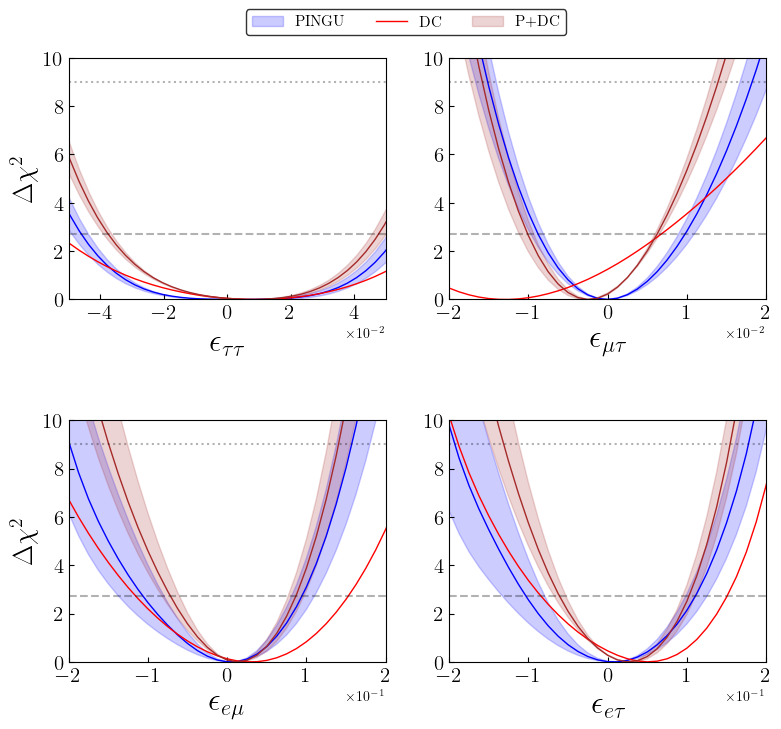

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(9, 8), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [
    r"$\epsilon_{\tau\tau}$",
    r"$\epsilon_{\mu\tau}$",
    r"$\epsilon_{e\mu}$",
    r"$\epsilon_{e\tau}$",
]
demidovs = [demidov_ett, demidov_emt, demidov_eem, demidov_eet]
alpha_regions = 0.2
alpha_lines = 1
lw = 1
xy_limits = [(5e-2, 10), (2e-2, 10), (2e-1, 10), (2e-1, 10)]
for i in range(4):
    ax[i].fill_between(
        fine_e_ranges[i],
        worst_cases[f"P_{nsi_list[i]}"],
        best_cases[f"P_{nsi_list[i]}"],
        label="PINGU",
        alpha=alpha_regions,
        color="b",
    )
    ax[i].plot(
        fine_e_ranges[i],
        normal_cases[f"P_{nsi_list[i]}"],
        alpha=alpha_lines,
        color="b",
        lw=lw,
    )
    ax[i].plot(
        fine_e_ranges[i],
        normal_cases[f"D_{nsi_list[i]}"],
        label="DC",
        alpha=alpha_lines,
        color="r",
        lw=lw,
    )
    ax[i].fill_between(
        fine_e_ranges[i],
        worst_cases[f"PD_{nsi_list[i]}"],
        best_cases[f"PD_{nsi_list[i]}"],
        label="P+DC",
        alpha=alpha_regions,
        color="brown",
    )
    ax[i].plot(
        fine_e_ranges[i],
        normal_cases[f"PD_{nsi_list[i]}"],
        alpha=1,
        color="brown",
        lw=lw,
    )

    ax[i].axhline(chi2.ppf(0.9, 1), alpha=0.3, c="black", ls="--")
    ax[i].axhline(chi2.ppf(0.9973, 1), alpha=0.3, c="black", ls=":")
    ax[i].set_ylim(bottom=0, top=xy_limits[i][1])
    ax[i].set_xlim((-xy_limits[i][0], xy_limits[i][0]))
    ax[i].set_xlabel(xlabels[i], fontsize=23)
    ax[i].tick_params(labelsize=15, axis="both", direction="in", which="both")
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

ax[0].set_ylabel(r"$\Delta \chi^2$", fontsize=20)
ax[2].set_ylabel(r"$\Delta \chi^2$", fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
leg = fig.legend(
    handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 0.95), fontsize=11
)
leg.get_frame().set_edgecolor("k")
plt.subplots_adjust(hspace=0.5)
# plt.savefig('./article/figures/joint_3D_NO.pdf', bbox_inches="tight")
# save(fig, 'joint_3D_NO') #Doesnt work, legend removed
# savethesis(fig, 'joint_3D_NO')#Doesnt work, legend removed

In [73]:
D_chisq, D_best_fit_index

(array([179.0615, 181.631 , 183.1995, 184.8611, 188.7748, 184.5998, 187.5626, 189.3163, 191.1671, 195.4383, 195.5392, 198.5671, 200.3661, 202.237 , 206.5533, 200.7859, 203.7821, 205.5626, 207.4054,
        211.646 , 213.0456, 215.8328, 217.486 , 219.2129, 223.2159, 160.6353, 163.6996, 165.5173, 167.4324, 171.8406, 160.7781, 164.1188, 166.0776, 168.1198, 172.8104, 165.1224, 168.5191, 170.5051,
        172.5704, 177.2935, 167.916 , 171.2802, 173.2437, 175.2873, 179.9583, 175.8758, 179.1014, 180.9941, 182.9615, 187.4615, 153.9681, 157.0346, 158.8558, 160.7654, 165.1903, 152.0555, 155.263 ,
        157.1594, 159.1401, 163.7084, 153.2103, 156.4159, 158.3031, 160.2736, 164.8215, 154.46  , 157.6267, 159.4898, 161.4349, 165.9248, 159.1388, 162.1752, 163.9638, 165.847 , 170.1944, 150.7263,
        153.4808, 155.1474, 156.9097, 161.0129, 147.833 , 150.6575, 152.3561, 154.1471, 158.3251, 147.9202, 150.6918, 152.3591, 154.1211, 158.2286, 148.6117, 151.3223, 152.9712, 154.697 , 158.7541,
        15

In [8]:
best_cases["P_eet"]

array([4.9428e+01, 4.2975e+01, 3.7301e+01, 3.2340e+01, 2.8029e+01, 2.4302e+01, 2.1096e+01, 1.8346e+01, 1.5987e+01, 1.3954e+01, 1.2183e+01, 1.0609e+01, 9.1688e+00, 7.8091e+00, 6.5293e+00, 5.3411e+00,
       4.2563e+00, 3.2865e+00, 2.4434e+00, 1.7356e+00, 1.1592e+00, 7.0698e-01, 3.7188e-01, 1.4680e-01, 2.4623e-02, 0.0000e+00, 7.4532e-02, 2.5157e-01, 5.3445e-01, 9.2654e-01, 1.4312e+00, 2.0542e+00,
       2.8115e+00, 3.7213e+00, 4.8021e+00, 6.0722e+00, 7.5499e+00, 9.2633e+00, 1.1279e+01, 1.3675e+01, 1.6527e+01, 1.9911e+01, 2.3905e+01, 2.8585e+01, 3.4029e+01, 4.0312e+01, 4.7511e+01, 5.5704e+01,
       6.4967e+01])

In [18]:
np.round(
    sproot(
        splrep(
            fine_e_ranges[0],
            normal_cases[f"P_ett"] - chi2.ppf(0.9973, 1),
            xb=fine_e_ranges[0][0] * 1.5,
            xe=fine_e_ranges[0][-1] * 1.5,
        )
    ),
    3,
)

array([-0.065,  0.073])

In [19]:
np.round(
    sproot(
        splrep(
            fine_e_ranges[0],
            best_cases[f"P_ett"] - chi2.ppf(0.9973, 1),
            xb=fine_e_ranges[0][0] * 1.5,
            xe=fine_e_ranges[0][-1] * 1.5,
        )
    ),
    3,
)

array([-0.062,  0.069])

In [72]:
best_cases[f"I_emt"]

array([6.3859e+01, 5.4778e+01, 4.6679e+01, 3.9499e+01, 3.3176e+01, 2.7648e+01, 2.2852e+01, 1.8728e+01, 1.5212e+01, 1.2242e+01, 9.7556e+00, 7.6916e+00, 5.9873e+00, 4.5853e+00, 3.4472e+00, 2.5393e+00,
       1.8280e+00, 1.2796e+00, 8.6055e-01, 5.4091e-01, 3.0612e-01, 1.4542e-01, 4.8011e-02, 3.1321e-03, 0.0000e+00, 3.1929e-02, 1.0860e-01, 2.4377e-01, 4.5121e-01, 7.4470e-01, 1.1380e+00, 1.6487e+00,
       2.3100e+00, 3.1588e+00, 4.2320e+00, 5.5666e+00, 7.1995e+00, 9.1725e+00, 1.1546e+01, 1.4385e+01, 1.7754e+01, 2.1719e+01, 2.6345e+01, 3.1696e+01, 3.7838e+01, 4.4836e+01, 5.2755e+01, 6.1661e+01,
       7.1617e+01])

In [77]:
1 - chi2.sf(np.min(P_chisq), 2)

4.7553599169525285e-08

In [57]:
index_list = ["$\ett$", "$\emt$", "$\eem$", "$\eet$"]
colnames = ["Best 90", "Best 3s", "Normal 90", "Normal 3s", "Worst 90", "Worst 3s"]
df_I = pd.DataFrame(columns=colnames, index=index_list, dtype=object)
df_D = pd.DataFrame(columns=colnames, index=index_list, dtype=object)
df_ID = pd.DataFrame(columns=colnames, index=index_list, dtype=object)

df_P = pd.DataFrame(columns=colnames, index=index_list, dtype=object)
df_PD = pd.DataFrame(columns=colnames, index=index_list, dtype=object)
df_PID = pd.DataFrame(columns=colnames, index=index_list, dtype=object)

cl90 = chi2.ppf(0.9, 1)
cl3s = chi2.ppf(0.9973, 1)
factors = [1e0, 1e0, 1e0, 1e0]
experiment_list1 = ["P", "D", "PD"]
experiment_list2 = ["I", "ID", "PID"]
for i, epsilon in enumerate(nsi_list):
    for j, df in enumerate([df_P, df_D, df_PD]):
        try:
            df.loc[index_list[i], f"Best 90"] = np.round(
                factors[i]
                * sproot(
                    splrep(
                        fine_e_ranges[i],
                        best_cases[f"{experiment_list1[j]}_{epsilon}"] - cl90,
                    )
                ),
                3,
            )
            df.loc[index_list[i], f"Best 3s"] = np.round(
                factors[i]
                * sproot(
                    splrep(
                        fine_e_ranges[i],
                        best_cases[f"{experiment_list1[j]}_{epsilon}"] - cl3s,
                        xb=fine_e_ranges[i][0] * 1.5,
                        xe=fine_e_ranges[i][-1] * 1.5,
                    )
                ),
                3,
            )  # Extrapolate

            df.loc[index_list[i], f"Normal 90"] = np.round(
                factors[i]
                * sproot(
                    splrep(
                        fine_e_ranges[i],
                        normal_cases[f"{experiment_list1[j]}_{epsilon}"] - cl90,
                    )
                ),
                3,
            )
            df.loc[index_list[i], f"Normal 3s"] = np.round(
                factors[i]
                * sproot(
                    splrep(
                        fine_e_ranges[i],
                        normal_cases[f"{experiment_list1[j]}_{epsilon}"] - cl3s,
                        xb=fine_e_ranges[i][0] * 1.5,
                        xe=fine_e_ranges[i][-1] * 1.5,
                    )
                ),
                3,
            )  # Extrapolate

            df.loc[index_list[i], f"Worst 90"] = np.round(
                factors[i]
                * sproot(
                    splrep(
                        fine_e_ranges[i],
                        worst_cases[f"{experiment_list1[j]}_{epsilon}"] - cl90,
                    )
                ),
                3,
            )
            df.loc[index_list[i], f"Worst 3s"] = np.round(
                factors[i]
                * sproot(
                    splrep(
                        fine_e_ranges[i],
                        worst_cases[f"{experiment_list1[j]}_{epsilon}"] - cl3s,
                        xb=fine_e_ranges[i][0] * 1.5,
                        xe=fine_e_ranges[i][-1] * 1.5,
                    )
                ),
                3,
            )  # Extrapolate
        except KeyError:
            pass
for i, df1 in enumerate([df_I, df_ID, df_PID]):
    df1.loc[index_list[1], f"Best 90"] = np.round(
        factors[i]
        * sproot(
            splrep(fine_e_ranges[1], best_cases[f"{experiment_list2[i]}_emt"] - cl90)
        ),
        3,
    )
    df1.loc[index_list[1], f"Best 3s"] = np.round(
        factors[i]
        * sproot(
            splrep(
                fine_e_ranges[1],
                best_cases[f"{experiment_list2[i]}_emt"] - cl3s,
                xb=fine_e_ranges[1][0] * 1.5,
                xe=fine_e_ranges[1][-1] * 1.5,
            )
        ),
        3,
    )

    df1.loc[index_list[1], f"Normal 90"] = np.round(
        factors[i]
        * sproot(
            splrep(fine_e_ranges[1], normal_cases[f"{experiment_list2[i]}_emt"] - cl90)
        ),
        3,
    )
    df1.loc[index_list[1], f"Normal 3s"] = np.round(
        factors[i]
        * sproot(
            splrep(
                fine_e_ranges[1],
                normal_cases[f"{experiment_list2[i]}_emt"] - cl3s,
                xb=fine_e_ranges[1][0] * 1.5,
                xe=fine_e_ranges[1][-1] * 1.5,
            )
        ),
        3,
    )

    df1.loc[index_list[1], f"Worst 90"] = np.round(
        factors[i]
        * sproot(
            splrep(fine_e_ranges[1], worst_cases[f"{experiment_list2[i]}_emt"] - cl90)
        ),
        3,
    )
    df1.loc[index_list[1], f"Worst 3s"] = np.round(
        factors[i]
        * sproot(
            splrep(
                fine_e_ranges[1],
                worst_cases[f"{experiment_list2[i]}_emt"] - cl3s,
                xb=fine_e_ranges[1][0] * 1.5,
                xe=fine_e_ranges[1][-1] * 1.5,
            )
        ),
        3,
    )

In [33]:
for i, epsilon in enumerate(nsi_list):
    for j, df in enumerate([df_D, df_P, df_PD]):
        print(nsi_list[i], experiment_list[j])
        print("Best")
        print(
            np.round(
                sproot(
                    splrep(
                        fine_e_ranges[i],
                        best_cases[f"{experiment_list[j]}_{epsilon}"] - cl90,
                    )
                ),
                3,
            )
        )
        print(
            np.round(
                sproot(
                    splrep(
                        fine_e_ranges[i],
                        best_cases[f"{experiment_list[j]}_{epsilon}"] - cl3s,
                        xb=fine_e_ranges[i][0] * 1.5,
                        xe=fine_e_ranges[i][-1] * 1.5,
                    )
                ),
                3,
            )
        )
        print("Normal")
        print(
            np.round(
                sproot(
                    splrep(
                        fine_e_ranges[i],
                        normal_cases[f"{experiment_list[j]}_{epsilon}"] - cl90,
                    )
                ),
                3,
            )
        )
        print(
            np.round(
                sproot(
                    splrep(
                        fine_e_ranges[i],
                        normal_cases[f"{experiment_list[j]}_{epsilon}"] - cl3s,
                        xb=fine_e_ranges[i][0] * 1.5,
                        xe=fine_e_ranges[i][-1] * 1.5,
                    )
                ),
                3,
            )
        )
        print("worst")
        print(
            np.round(
                sproot(
                    splrep(
                        fine_e_ranges[i],
                        worst_cases[f"{experiment_list[j]}_{epsilon}"] - cl90,
                    )
                ),
                3,
            )
        )
        print(
            np.round(
                sproot(
                    splrep(
                        fine_e_ranges[i],
                        worst_cases[f"{experiment_list[j]}_{epsilon}"] - cl3s,
                        xb=fine_e_ranges[i][0] * 1.5,
                        xe=fine_e_ranges[i][-1] * 1.5,
                    )
                ),
                3,
            )
        )

ett P
Best
[-0.044  0.051]
[-0.062  0.069]
Normal
[-0.046  0.054]
[-0.065  0.073]
worst
[-0.049  0.057]
[-0.07   0.078]
ett D
Best
[-0.054  0.067]
[-0.089  0.101]
Normal
[-0.054  0.067]
[-0.089  0.101]
worst
[-0.054  0.067]
[-0.089  0.101]
ett PD
Best
[-0.036  0.046]
[-0.056  0.064]
Normal
[-0.038  0.048]
[-0.058  0.067]
worst
[-0.039  0.05 ]
[-0.06  0.07]
emt P
Best
[-0.008  0.009]
[-0.014  0.017]
Normal
[-0.009  0.01 ]
[-0.015  0.018]
worst
[-0.01   0.011]
[-0.017  0.02 ]
emt D
Best
[-0.029  0.007]
[-0.041  0.026]
Normal
[-0.029  0.007]
[-0.041  0.026]
worst
[-0.029  0.007]
[-0.041  0.026]
emt PD
Best
[-0.009  0.006]
[-0.015  0.013]
Normal
[-0.01   0.006]
[-0.016  0.014]
worst
[-0.011  0.007]
[-0.017  0.015]
eem P
Best
[-0.079  0.081]
[-0.16   0.138]
Normal
[-0.106  0.094]
[-0.199  0.157]
worst
[-0.137  0.11 ]
[-0.228  0.18 ]
eem D
Best
[-0.115  0.152]
[-0.234  0.242]
Normal
[-0.115  0.152]
[-0.234  0.242]
worst
[-0.115  0.152]
[-0.234  0.242]
eem PD
Best
[-0.06   0.077]
[-0.126  0.1

In [48]:
df_P

,Best 90,Best 3s,Normal 90,Normal 3s,Worst 90,Worst 3s
$\ett$,NaN,NaN,NaN,NaN,NaN,NaN
$\emt$,"[-0.012, 0.011]","[-0.017, 0.016]","[-0.015, 0.014]","[-0.022, 0.021]","[-0.018, 0.017]","[-0.025, 0.024]"
$\eem$,NaN,NaN,NaN,NaN,NaN,NaN
$\eet$,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
ID_table = pd.concat([df_I, df_D, df_ID]).dropna()

PID_table = pd.concat([df_P, df_PD, df_PID]).dropna()

In [59]:
ID_table_best = ID_table.loc[:, ("Best 90", "Best 3s")]
ID_table_normal = ID_table.loc[:, ("Normal 90", "Normal 3s")]
ID_table_worst = ID_table.loc[:, ("Worst 90", "Worst 3s")]

PID_table_best = PID_table.loc[:, ("Best 90", "Best 3s")]
PID_table_normal = PID_table.loc[:, ("Normal 90", "Normal 3s")]
PID_table_worst = PID_table.loc[:, ("Worst 90", "Worst 3s")]

In [60]:
print(
    ID_table_best.to_latex(
        header=["Best 90\% CL", "Best $3\sigma$"],
        index_names=True,
        column_format="lcc",
        escape=False,
    )
)

\begin{tabular}{lcc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ \\
\midrule
$\emt$ &  [-0.012, 0.011] &  [-0.017, 0.016] \\
$\ett$ &  [-0.054, 0.067] &  [-0.089, 0.101] \\
$\emt$ &  [-0.029, 0.007] &  [-0.041, 0.026] \\
$\eem$ &  [-0.115, 0.152] &  [-0.234, 0.242] \\
$\eet$ &   [-0.084, 0.15] &  [-0.188, 0.212] \\
$\emt$ &  [-0.013, 0.007] &  [-0.017, 0.013] \\
\bottomrule
\end{tabular}



In [62]:
print(
    ID_table_normal.to_latex(
        header=["Normal 90\% CL", "Normal $3\sigma$"],
        index_names=True,
        column_format="lcc",
        escape=False,
    )
)

\begin{tabular}{lcc}
\toprule
{} &   Normal 90\% CL & Normal $3\sigma$ \\
\midrule
$\emt$ &  [-0.015, 0.014] &  [-0.022, 0.021] \\
$\ett$ &  [-0.054, 0.067] &  [-0.089, 0.101] \\
$\emt$ &  [-0.029, 0.007] &  [-0.041, 0.026] \\
$\eem$ &  [-0.115, 0.152] &  [-0.234, 0.242] \\
$\eet$ &   [-0.084, 0.15] &  [-0.188, 0.212] \\
$\emt$ &  [-0.016, 0.007] &  [-0.022, 0.016] \\
\bottomrule
\end{tabular}



In [66]:
print(
    ID_table_worst.to_latex(
        header=["Worst 90\% CL", "Worst $3\sigma$"],
        index_names=True,
        column_format="lcc",
        escape=False,
    )
)

\begin{tabular}{lcc}
\toprule
{} &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\emt$ &  [-0.018, 0.017] &  [-0.025, 0.024] \\
$\ett$ &  [-0.054, 0.067] &  [-0.089, 0.101] \\
$\emt$ &  [-0.029, 0.007] &  [-0.041, 0.026] \\
$\eem$ &  [-0.115, 0.152] &  [-0.234, 0.242] \\
$\eet$ &   [-0.084, 0.15] &  [-0.188, 0.212] \\
$\emt$ &  [-0.018, 0.007] &  [-0.024, 0.018] \\
\bottomrule
\end{tabular}



In [63]:
print(
    PID_table_best.to_latex(
        header=["Best 90\% CL", "Best $3\sigma$"],
        index_names=True,
        column_format="lcc",
        escape=False,
    )
)

\begin{tabular}{lcc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ \\
\midrule
$\ett$ &  [-0.044, 0.051] &  [-0.062, 0.069] \\
$\emt$ &  [-0.008, 0.009] &  [-0.014, 0.017] \\
$\eem$ &  [-0.079, 0.081] &   [-0.16, 0.138] \\
$\eet$ &  [-0.079, 0.098] &  [-0.148, 0.161] \\
$\ett$ &  [-0.036, 0.046] &  [-0.056, 0.064] \\
$\emt$ &  [-0.009, 0.006] &  [-0.015, 0.013] \\
$\eem$ &   [-0.06, 0.077] &  [-0.126, 0.127] \\
$\eet$ &  [-0.052, 0.095] &  [-0.112, 0.144] \\
$\emt$ &  [-0.008, 0.005] &  [-0.012, 0.011] \\
\bottomrule
\end{tabular}



In [64]:
print(
    PID_table_normal.to_latex(
        header=["Normal 90\% CL", "Normal $3\sigma$"],
        index_names=True,
        column_format="lcc",
        escape=False,
    )
)

\begin{tabular}{lcc}
\toprule
{} &   Normal 90\% CL & Normal $3\sigma$ \\
\midrule
$\ett$ &  [-0.046, 0.054] &  [-0.065, 0.073] \\
$\emt$ &   [-0.009, 0.01] &  [-0.015, 0.018] \\
$\eem$ &  [-0.106, 0.094] &  [-0.199, 0.157] \\
$\eet$ &   [-0.103, 0.11] &  [-0.193, 0.178] \\
$\ett$ &  [-0.038, 0.048] &  [-0.058, 0.067] \\
$\emt$ &   [-0.01, 0.006] &  [-0.016, 0.014] \\
$\eem$ &  [-0.071, 0.086] &  [-0.149, 0.141] \\
$\eet$ &  [-0.061, 0.103] &  [-0.131, 0.155] \\
$\emt$ &  [-0.009, 0.006] &  [-0.014, 0.012] \\
\bottomrule
\end{tabular}



In [65]:
print(
    PID_table_worst.to_latex(
        header=["Worst 90\% CL", "Worst $3\sigma$"],
        index_names=True,
        column_format="lcc",
        escape=False,
    )
)

\begin{tabular}{lcc}
\toprule
{} &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\ett$ &  [-0.049, 0.057] &   [-0.07, 0.078] \\
$\emt$ &   [-0.01, 0.011] &   [-0.017, 0.02] \\
$\eem$ &   [-0.137, 0.11] &   [-0.228, 0.18] \\
$\eet$ &  [-0.132, 0.125] &  [-0.226, 0.196] \\
$\ett$ &   [-0.039, 0.05] &    [-0.06, 0.07] \\
$\emt$ &  [-0.011, 0.007] &  [-0.017, 0.015] \\
$\eem$ &  [-0.082, 0.097] &  [-0.168, 0.155] \\
$\eet$ &  [-0.067, 0.111] &  [-0.147, 0.165] \\
$\emt$ &   [-0.01, 0.006] &  [-0.016, 0.013] \\
\bottomrule
\end{tabular}

